[a] Saved dataset -> C:\DATA\data_4.2.csv  shape=(10000, 22)  (20 features + targets)


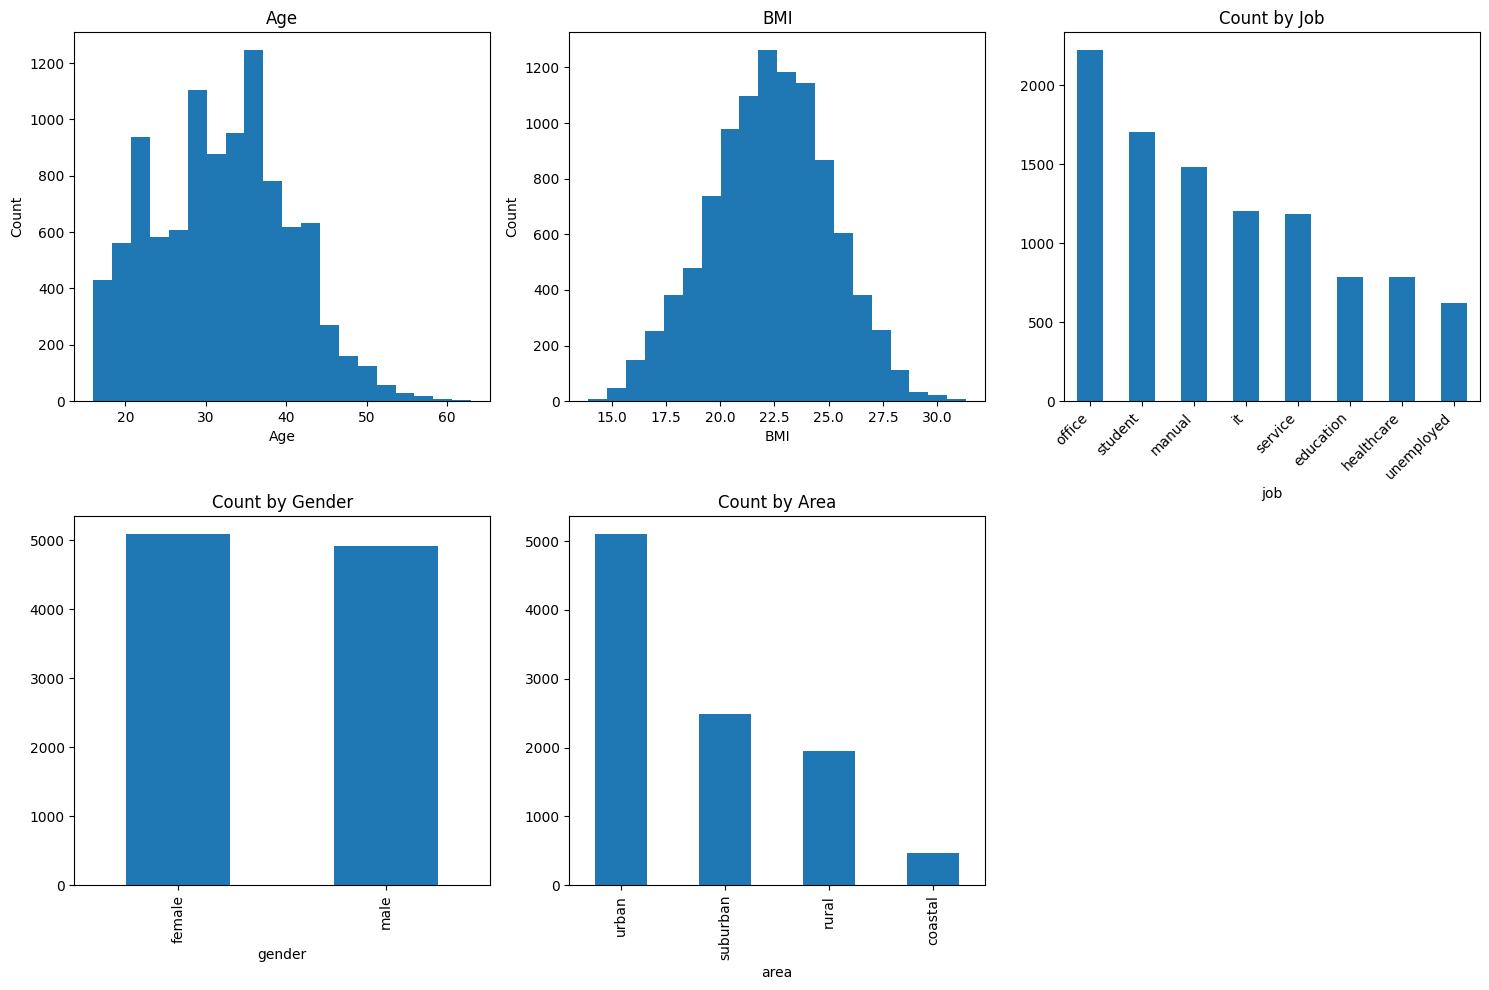


=== Basic Classification (label) ===
 Model  Accuracy    MAE    MSE     RMSE
LogReg    0.9880 0.0180 0.0300 0.173205
    GB    0.9825 0.0235 0.0355 0.188414
   SVM    0.9530 0.0675 0.1085 0.329393
    RF    0.9080 0.1235 0.1865 0.431856
   KNN    0.7725 0.3165 0.4945 0.703207

=== Basic Regression (BMI) ===
 Model  Accuracy      MAE      MSE     RMSE
LinReg       NaN 2.222843 7.578304 2.752872
 GBReg       NaN 2.226504 7.613905 2.759331
 RFReg       NaN 2.236272 7.694708 2.773934
   SVR       NaN 2.229518 7.719298 2.778362
KNNReg       NaN 2.354593 8.555430 2.924967


In [ ]:
# ====================== 4.2 (a→i) ONE CELL — BUILD & RUN WEB APP ======================
# Yêu cầu pip: numpy pandas scikit-learn matplotlib tensorflow flask joblib

import os, json, math, warnings, pickle, time, webbrowser, textwrap, random
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error, confusion_matrix

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.svm import SVC, SVR
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor

import joblib
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models

from flask import Flask, request, jsonify, render_template_string
from threading import Thread

# ---------------- Paths & setup ----------------
OUT_DIR = r"C:\DATA"
os.makedirs(OUT_DIR, exist_ok=True)
csv_path = os.path.join(OUT_DIR, "data_4.2.csv")
kb_path  = os.path.join(OUT_DIR, "kb_healthGuide.json")
assets_dir = os.path.join(OUT_DIR, "models_4_2")
os.makedirs(assets_dir, exist_ok=True)

rng = np.random.default_rng(2025)

# ======================================================================================
# (a) Build dataset: 10,000 persons & 20 features  -> save to C:\DATA\data_4.2.csv
# ======================================================================================
N = 10_000

jobs = ["student","office","manual","service","unemployed","healthcare","it","education"]
areas = ["urban","suburban","rural","coastal"]
genders = ["male","female"]

def sample_categorical(ops, p=None, n=N):
    idx = rng.choice(len(ops), size=n, p=p)
    return [ops[i] for i in idx], idx

job, job_idx = sample_categorical(jobs, p=[.18,.22,.14,.12,.06,.08,.12,.08])
area, area_idx = sample_categorical(areas, p=[.5,.25,.2,.05])
gender, gender_idx = sample_categorical(genders, p=[.49,.51])

# tuổi theo nghề
age_means  = np.array([21, 35, 38, 30, 32, 34, 33, 36])
age_stds   = np.array([ 3,  7,  8,  6,  7,  6,  6,  7])
age = np.clip(rng.normal(age_means[job_idx], age_stds[job_idx]), 16, 70).round().astype(int)

# chiều cao theo giới + nghề
h_base = np.where(np.array(gender_idx)==0, 171, 159)  # nam cao hơn nữ
h_job  = np.array([0,-1, 1,-1,-1, 0, 0, -1])[job_idx]
height_cm = np.clip(h_base + h_job + rng.normal(0, 6, size=N), 145, 200).round(1)

# cân nặng: dựa vào cao + thiên kiến nghề + lối sống
base_w = 0.9*(height_cm - 100) + np.where(np.array(gender_idx)==0, 4.0, 0.0)
job_bias = np.array([-2.0, 1.0, 3.0, 0.5, -0.5, 0.3, 0.8, 0.0])[job_idx]
area_bias = np.array([0.5, 0.0, -0.3, -0.2])[area_idx]
activity_level = rng.choice([1,2,3,4,5], size=N, p=[.15,.25,.35,.2,.05])  # 1 thấp → 5 cao
activity_bias = (3 - activity_level) * 0.9  # hoạt động thấp → nặng hơn
weight_kg = base_w + job_bias + area_bias + activity_bias + rng.normal(0, 6.5, size=N)
weight_kg = np.clip(weight_kg, 38, 150).round(1)

# thêm 20 feature (bao gồm những trên):
diet_type = rng.choice(["balanced","high_carb","keto","high_protein","random"], size=N, p=[.45,.22,.08,.2,.05])
smoker = rng.choice([0,1], size=N, p=[.85,.15])
alcohol = rng.choice(["none","light","moderate","heavy"], size=N, p=[.35,.4,.2,.05])
sleep_hours = np.clip(rng.normal(7.1, 1.1, size=N), 3.5, 10.5).round(1)
blood_pressure = np.clip(rng.normal(118, 12, size=N) + (age-35)*0.2 + smoker*4, 90, 180).round(0)
cholesterol = np.clip(rng.normal(185, 30, size=N) + (smoker*8) + (3-activity_level)*5, 120, 300).round(0)
sugar_intake = np.clip(rng.normal(60, 25, size=N) + (diet_type=="high_carb")*20 - (diet_type=="keto")*25, 5, 200).round(0)  # g/day
salt_intake  = np.clip(rng.normal(8.5, 2.2, size=N) + (alcohol=="heavy")*1.2, 2, 20).round(1) # g/day
steps_per_day = np.clip(rng.normal(6500, 2500, size=N) + (activity_level-3)*1200, 500, 20000).round(0)
screen_time = np.clip(rng.normal(5, 2.2, size=N) + (jobs.index("it")==np.array(job_idx))*1.0, 0.5, 14).round(1)
meals_per_day = rng.choice([2,3,4,5], size=N, p=[.1,.6,.25,.05])
water_intake = np.clip(rng.normal(1.9, .7, size=N) + (activity_level-3)*0.2, 0.5, 5.0).round(1) # L/day
stress_level = rng.choice([1,2,3,4,5], size=N, p=[.12,.24,.32,.22,.10])

# BMI + nhãn
bmi = weight_kg / (height_cm/100.0)**2
def bmi_to_label(x):
    if x < 18.5: return "underweight"
    if x < 25.0: return "normal"
    return "overweight"
label = np.array([bmi_to_label(x) for x in bmi])

# DataFrame 20 features
df = pd.DataFrame({
    "job": job,
    "area": area,
    "gender": gender,
    "age": age,
    "height_cm": height_cm,
    "weight_kg": weight_kg,
    "activity_level": activity_level,
    "diet_type": diet_type,
    "smoker": smoker,
    "alcohol": alcohol,
    "sleep_hours": sleep_hours,
    "blood_pressure": blood_pressure,
    "cholesterol": cholesterol,
    "sugar_intake_g": sugar_intake,
    "salt_intake_g": salt_intake,
    "steps_per_day": steps_per_day,
    "screen_time_h": screen_time,
    "meals_per_day": meals_per_day,
    "water_intake_L": water_intake,
    "stress_level": stress_level,
    "bmi": bmi.round(2),
    "label": label
})
df.to_csv(csv_path, index=False, encoding="utf-8")
print(f"[a] Saved dataset -> {csv_path}  shape={df.shape}  (20 features + targets)")

# ======================================================================================
# (b) Distribution plots (>=5)
# ======================================================================================
plt.figure(figsize=(15,10))
plt.subplot(2,3,1); plt.hist(df["age"], bins=20); plt.title("Age"); plt.xlabel("Age"); plt.ylabel("Count")
plt.subplot(2,3,2); plt.hist(df["bmi"], bins=20); plt.title("BMI"); plt.xlabel("BMI"); plt.ylabel("Count")
plt.subplot(2,3,3); df["job"].value_counts().plot(kind="bar"); plt.title("Count by Job"); plt.xticks(rotation=45, ha="right")
plt.subplot(2,3,4); df["gender"].value_counts().plot(kind="bar"); plt.title("Count by Gender")
plt.subplot(2,3,5); df["area"].value_counts().plot(kind="bar"); plt.title("Count by Area")
plt.tight_layout(); plt.show()

# ======================================================================================
# (c) 5 basic ML models — Classification (label) + Regression (BMI)
# ======================================================================================
# Features chọn cho mô hình: gồm cả số & danh mục
feature_cols = [
    "job","area","gender","age","height_cm","weight_kg",
    "activity_level","diet_type","smoker","alcohol","sleep_hours",
    "blood_pressure","cholesterol","sugar_intake_g","salt_intake_g",
    "steps_per_day","screen_time_h","meals_per_day","water_intake_L","stress_level"
]

X = df[feature_cols].copy()
y_cls = df["label"].copy()    # classification target
y_reg = df["bmi"].astype(float).copy()  # regression target (predict BMI)

# encoders
le_y = LabelEncoder()
y_int = le_y.fit_transform(y_cls)

cat_cols = ["job","area","gender","diet_type","alcohol"]
num_cols = [c for c in feature_cols if c not in cat_cols]

preprocess_cls = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ("num", StandardScaler(), num_cols)
    ]
)
preprocess_reg = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ("num", StandardScaler(), num_cols)
    ]
)

Xtr, Xte, ytr_cls, yte_cls = train_test_split(X, y_int, test_size=0.2, random_state=42, stratify=y_int)
_,   _,   ytr_reg, yte_reg = train_test_split(X, y_reg, test_size=0.2, random_state=42)  # tách đồng bộ

basic_cls = {
    "LogReg": LogisticRegression(max_iter=1000, multi_class="auto"),
    "SVM": SVC(probability=True),
    "RF": RandomForestClassifier(n_estimators=300, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=11),
    "GB": GradientBoostingClassifier(random_state=42)
}
basic_reg = {
    "LinReg": LinearRegression(),
    "RFReg": RandomForestRegressor(n_estimators=300, random_state=42),
    "GBReg": GradientBoostingRegressor(random_state=42),
    "KNNReg": KNeighborsRegressor(n_neighbors=7),
    "SVR": SVR()
}

def eval_cls_dict(models_dict):
    out = {}
    for name, clf in models_dict.items():
        pipe = Pipeline([("prep", preprocess_cls), ("clf", clf)])
        pipe.fit(Xtr, ytr_cls)
        yhat = pipe.predict(Xte)
        acc = accuracy_score(yte_cls, yhat)
        mae = mean_absolute_error(yte_cls, yhat)
        mse = mean_squared_error(yte_cls, yhat)
        rmse = math.sqrt(mse)
        out[name] = {"acc":acc,"mae":mae,"mse":mse,"rmse":rmse,"model":pipe}
    return out

def eval_reg_dict(models_dict):
    out = {}
    for name, reg in models_dict.items():
        pipe = Pipeline([("prep", preprocess_reg), ("reg", reg)])
        pipe.fit(Xtr, ytr_reg)
        yhat = pipe.predict(Xte)
        mae = mean_absolute_error(yte_reg, yhat)
        mse = mean_squared_error(yte_reg, yhat)
        rmse = math.sqrt(mse)
        # accuracy không áp dụng cho hồi quy; để trống
        out[name] = {"acc":np.nan,"mae":mae,"mse":mse,"rmse":rmse,"model":pipe}
    return out

basic_cls_res = eval_cls_dict(basic_cls)
basic_reg_res = eval_reg_dict(basic_reg)

def table_from(resdict):
    rows = []
    for k,v in resdict.items():
        rows.append([k, v["acc"], v["mae"], v["mse"], v["rmse"]])
    dfres = pd.DataFrame(rows, columns=["Model","Accuracy","MAE","MSE","RMSE"])
    return dfres

print("\n=== Basic Classification (label) ===")
print(table_from(basic_cls_res).sort_values("Accuracy", ascending=False).to_string(index=False))

print("\n=== Basic Regression (BMI) ===")
print(table_from(basic_reg_res).sort_values("RMSE", ascending=True).to_string(index=False))

# ======================================================================================
# (d) Deep models: CNN, RNN, LSTM (>=5 layers) for classification
# + MLP (>=5 layers) for BMI regression
# ======================================================================================
# Chuẩn hóa numeric -> tensor (sequence length = 20, channels = 1)
# Encode category -> số index (đơn giản) rồi chuẩn hóa
cat_maps = {
    "job": {v:i for i,v in enumerate(jobs)},
    "area": {v:i for i,v in enumerate(areas)},
    "gender": {v:i for i,v in enumerate(genders)},
    "diet_type": {v:i for i,v in enumerate(["balanced","high_carb","keto","high_protein","random"])},
    "alcohol": {v:i for i,v in enumerate(["none","light","moderate","heavy"])}
}

def _to_numeric_row(row):
    arr = []
    for c in feature_cols:
        if c in cat_maps:
            arr.append(float(cat_maps[c][row[c]]))
        else:
            arr.append(float(row[c]))
    return np.array(arr, dtype=float)

Xn_all = np.vstack([_to_numeric_row(r) for _,r in X.iterrows()])
scaler_all = StandardScaler()
Xn_all = scaler_all.fit_transform(Xn_all)

Xn_tr, Xn_te = Xn_all[Xtr.index], Xn_all[Xte.index]

num_classes = len(le_y.classes_)
ytr_oh = keras.utils.to_categorical(ytr_cls, num_classes)
yte_oh = keras.utils.to_categorical(yte_cls, num_classes)

# reshape cho 1D conv/rnn (seq_len=20, channels=1)
Xseq_tr = Xn_tr.reshape((-1, Xn_tr.shape[1], 1))
Xseq_te = Xn_te.reshape((-1, Xn_te.shape[1], 1))

def build_cnn_cls(input_len=20, classes=3):
    model = models.Sequential([
        layers.Conv1D(32, 3, activation="relu", input_shape=(input_len,1)),
        layers.BatchNormalization(),
        layers.Conv1D(64, 3, activation="relu"),
        layers.BatchNormalization(),
        layers.MaxPooling1D(2),
        layers.Conv1D(128, 3, activation="relu"),
        layers.GlobalAveragePooling1D(),
        layers.Dense(64, activation="relu"),
        layers.Dense(classes, activation="softmax")
    ])
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    return model  # >=6 layers

def build_rnn_cls(input_len=20, classes=3):
    model = models.Sequential([
        layers.SimpleRNN(64, return_sequences=True, input_shape=(input_len,1)),
        layers.Dropout(0.2),
        layers.SimpleRNN(64, return_sequences=True),
        layers.Dropout(0.2),
        layers.SimpleRNN(32),
        layers.Dense(64, activation="relu"),
        layers.Dense(classes, activation="softmax")
    ])
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    return model  # >=7 layers

def build_lstm_cls(input_len=20, classes=3):
    model = models.Sequential([
        layers.LSTM(64, return_sequences=True, input_shape=(input_len,1)),
        layers.Dropout(0.2),
        layers.LSTM(64, return_sequences=True),
        layers.Dropout(0.2),
        layers.LSTM(32),
        layers.Dense(64, activation="relu"),
        layers.Dense(classes, activation="softmax")
    ])
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    return model  # >=7 layers

cnn = build_cnn_cls(Xseq_tr.shape[1], num_classes)
rnn = build_rnn_cls(Xseq_tr.shape[1], num_classes)
lstm = build_lstm_cls(Xseq_tr.shape[1], num_classes)

dl_hist = {}
for name, m in {"CNN":cnn, "RNN":rnn, "LSTM":lstm}.items():
    h = m.fit(Xseq_tr, ytr_oh, epochs=12, batch_size=128, verbose=0, validation_split=0.2, shuffle=True)
    dl_hist[name] = h

def eval_dl_cls(model):
    pred = np.argmax(model.predict(Xseq_te, verbose=0), axis=1)
    acc = accuracy_score(yte_cls, pred)
    mae = mean_absolute_error(yte_cls, pred)
    mse = mean_squared_error(yte_cls, pred)
    rmse = math.sqrt(mse)
    return {"acc":acc,"mae":mae,"mse":mse,"rmse":rmse,"model":model}

dl_cls_res = {
    "CNN": eval_dl_cls(cnn),
    "RNN": eval_dl_cls(rnn),
    "LSTM": eval_dl_cls(lstm)
}

# MLP Regression (BMI) ≥5 layers
def build_mlp_reg(input_dim=20):
    inp = layers.Input(shape=(input_dim,))
    x = layers.Dense(128, activation="relu")(inp)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dense(32, activation="relu")(x)
    x = layers.Dense(16, activation="relu")(x)
    out = layers.Dense(1)(x)
    model = keras.Model(inp, out)
    model.compile(optimizer="adam", loss="mse", metrics=["mae"])
    return model

mlp_reg = build_mlp_reg(Xn_tr.shape[1])
mlp_reg.fit(Xn_tr, ytr_reg.values, epochs=12, batch_size=128, verbose=0, validation_split=0.2, shuffle=True)
yhat_mlp = mlp_reg.predict(Xn_te, verbose=0).reshape(-1)
mae_mlp = mean_absolute_error(yte_reg, yhat_mlp)
mse_mlp = mean_squared_error(yte_reg, yhat_mlp)
rmse_mlp = math.sqrt(mse_mlp)
dl_reg_res = {"MLPReg": {"acc":np.nan, "mae":mae_mlp, "mse":mse_mlp, "rmse":rmse_mlp, "model":mlp_reg}}

print("\n=== Deep Classification ===")
print(table_from(dl_cls_res).sort_values("Accuracy", ascending=False).to_string(index=False))

print("\n=== Deep Regression (BMI) ===")
print(table_from(dl_reg_res).to_string(index=False))

# ======================================================================================
# (e) Compare & choose best classification model by Accuracy; show confusion matrix
# ======================================================================================
all_cls = {**basic_cls_res, **dl_cls_res}
tbl_all_cls = table_from(all_cls).sort_values("Accuracy", ascending=False)
print("\n=== ALL Classification Models (sorted by Accuracy) ===")
print(tbl_all_cls.to_string(index=False))

best_row = tbl_all_cls.iloc[0]
best_name = best_row["Model"]
best_is_basic = best_name in basic_cls_res
best_model_cls = (basic_cls_res if best_is_basic else dl_cls_res)[best_name]["model"]
print(f"\nBest classifier: {best_name} | Acc={best_row['Accuracy']:.4f}")

# confusion matrix (classifier)
if best_is_basic:
    y_hat = best_model_cls.predict(Xte)
else:
    y_hat = np.argmax(best_model_cls.predict(Xseq_te, verbose=0), axis=1)
cm = confusion_matrix(yte_cls, y_hat, labels=[0,1,2])
plt.figure(figsize=(5,4))
plt.imshow(cm, cmap="Blues")
plt.title(f"Confusion Matrix - {best_name}")
plt.xlabel("Predicted"); plt.ylabel("True")
classes = le_y.inverse_transform([0,1,2])
plt.xticks([0,1,2], classes); plt.yticks([0,1,2], classes)
for (i,j), v in np.ndenumerate(cm):
    plt.text(j, i, str(v), ha="center", va="center")
plt.colorbar(); plt.tight_layout(); plt.show()

# ======================================================================================
# (f) Visualizations: ai thừa cân nhiều nhất theo age, job, gender, area
# ======================================================================================
df["is_over"] = (df["label"]=="overweight").astype(int)

# theo nhóm tuổi (bins)
bins = [15,20,25,30,35,40,45,50,55,60,70]
age_group = pd.cut(df["age"], bins=bins, right=False)
over_by_age = df.groupby(age_group)["is_over"].mean().mul(100).round(1)
over_by_job = df.groupby("job")["is_over"].mean().mul(100).sort_values(ascending=False).round(1)
over_by_gender = df.groupby("gender")["is_over"].mean().mul(100).round(1)
over_by_area = df.groupby("area")["is_over"].mean().mul(100).sort_values(ascending=False).round(1)

plt.figure(figsize=(14,9))
plt.subplot(2,2,1); over_by_age.plot(kind="bar"); plt.title("% Overweight by Age Group"); plt.ylabel("%"); plt.xticks(rotation=45, ha="right")
plt.subplot(2,2,2); over_by_job.plot(kind="bar"); plt.title("% Overweight by Job"); plt.ylabel("%"); plt.xticks(rotation=45, ha="right")
plt.subplot(2,2,3); over_by_gender.plot(kind="bar"); plt.title("% Overweight by Gender"); plt.ylabel("%")
plt.subplot(2,2,4); over_by_area.plot(kind="bar"); plt.title("% Overweight by Area"); plt.ylabel("%")
plt.tight_layout(); plt.show()

print("\nWhich age group has more overweight (%):")
print(over_by_age.sort_values(ascending=False).head(5).to_string())
print("\nWhich job has more overweight (%):")
print(over_by_job.head(5).to_string())
print("\nWhich gender has more overweight (%):")
print(over_by_gender.sort_values(ascending=False).to_string())
print("\nWhich area has more overweight (%):")
print(over_by_area.to_string())

# ======================================================================================
# (g) Deploy best classifier (Flask) — user nhập feature → label + gợi ý
# ======================================================================================
# Lưu các artefacts cần thiết
joblib.dump(preprocess_cls, os.path.join(assets_dir, "preprocess_cls.joblib"))
joblib.dump(preprocess_reg, os.path.join(assets_dir, "preprocess_reg.joblib"))
joblib.dump(le_y,          os.path.join(assets_dir, "label_encoder.joblib"))
joblib.dump(scaler_all,    os.path.join(assets_dir, "scaler_all.joblib"))
if best_is_basic:
    joblib.dump(best_model_cls, os.path.join(assets_dir, f"{best_name}_classifier.joblib"))
else:
    best_model_cls.save(os.path.join(assets_dir, f"{best_name}_classifier_keras.h5"))
# Lưu reg tốt nhất (RMSE thấp nhất) để dự báo BMI
best_reg_name = sorted(basic_reg_res.items(), key=lambda kv: kv[1]["rmse"])[0][0]
best_reg = basic_reg_res[best_reg_name]["model"]
joblib.dump(best_reg, os.path.join(assets_dir, f"{best_reg_name}_regressor.joblib"))
mlp_reg.save(os.path.join(assets_dir, "MLPReg_keras.h5"))

# ======================================================================================
# (h) Build BIG Knowledge base (>3MB) -> C:\DATA\kb_healthGuide.json
# - Gồm lời khuyên theo nhãn + theo nghề/tuổi/giới/area/diet + hàng nghìn guideline snippet
# ======================================================================================
base_kb = {
    "categories": {
        "underweight": {
            "criteria": "BMI < 18.5",
            "tips": [
                "Tăng năng lượng và đạm chất lượng (thịt nạc, cá, trứng, sữa, đậu).",
                "Thêm 2–3 bữa phụ giàu năng lượng mỗi ngày.",
                "Tập sức mạnh 3 buổi/tuần để tăng khối cơ.",
                "Theo dõi thay đổi cân nặng hằng tuần."
            ]
        },
        "normal": {
            "criteria": "18.5 ≤ BMI < 25",
            "tips": [
                "Giữ cân bằng dinh dưỡng; 50–60% carb tốt, 15–25% đạm, 20–30% chất béo tốt.",
                "150–300 phút vận động/tuần; 2 buổi sức mạnh.",
                "Ngủ 7–9 giờ; quản lý stress; khám định kỳ."
            ]
        },
        "overweight": {
            "criteria": "BMI ≥ 25",
            "tips": [
                "Giảm thực phẩm siêu chế biến; ưu tiên rau, trái cây, đạm nạc.",
                "Tăng NEAT (đi bộ, leo thang); 8–10k bước/ngày.",
                "Mục tiêu giảm 5–10% cân nặng trong 3–6 tháng."
            ]
        }
    },
    "by_job": {
        j: [
            f"{j}: chuẩn bị bữa phù hợp ca làm/giờ học.",
            f"{j}: ưu tiên protein nạc sau giờ làm/giờ học.",
            f"{j}: thiết lập nhắc nhở vận động nhẹ mỗi 45–60 phút."
        ] for j in jobs
    },
    "by_area": {
        "urban": ["Đi bộ/xe đạp đoạn ngắn; kiểm soát suất ăn ngoài."],
        "suburban": ["Tận dụng công viên gần nhà; nấu ăn tại nhà nhiều hơn."],
        "rural": ["Tận dụng nông sản tươi; giữ lịch vận động đều."],
        "coastal": ["Ưu tiên hải sản nạc; đi bộ bãi biển buổi sáng."]
    },
    "by_gender": {
        "male": ["Tập sức mạnh nhóm cơ lớn; kiểm soát đồ uống có cồn."],
        "female": ["Bổ sung sắt, canxi hợp lý; theo dõi chu kỳ và giấc ngủ."]
    },
    "by_age_group": {
        "15-24": ["Tạo thói quen ăn lành mạnh sớm; hạn chế nước ngọt."],
        "25-34": ["Cân bằng công việc–vận động; ngủ đủ."],
        "35-44": ["Khám tổng quát định kỳ; theo dõi huyết áp, mỡ máu."],
        "45-60": ["Tăng đi bộ nhanh; giảm muối; theo dõi cân nặng."],
        "60-70": ["Vận động vừa phải hàng ngày; đủ đạm, vitamin D."]
    },
    "by_diet": {
        "balanced": ["Duy trì đa dạng thực phẩm; theo dõi khẩu phần."],
        "high_carb": ["Ưu tiên carb phức; kiểm soát đường đơn."],
        "keto": ["Theo dõi lipid máu; bổ sung chất xơ không tinh bột."],
        "high_protein": ["Đủ nước; đa dạng nguồn đạm; kiểm soát muối."],
        "random": ["Ghi nhật ký ăn uống 7 ngày để điều chỉnh."]
    }
}

# Tạo "library" lớn >3MB: nhân bản template câu khuyến nghị với biến thể ngẫu nhiên
phrases = [
    "Uống {x} ml nước trước bữa {y}.",
    "Đi bộ {x} bước sau bữa {y}.",
    "Thêm {x}g rau xanh vào bữa {y}.",
    "Giảm {x} phút màn hình trước khi ngủ.",
    "Tập {x} phút cardio vào {y}.",
    "Chuẩn bị snack đạm ~{x}g vào {y}.",
    "Giảm {x}g đường trong ngày.",
    "Ngủ trưa {x} phút để phục hồi.",
    "Thêm {x}g yến mạch bữa sáng {y}.",
    "Tập sức mạnh {x} hiệp cho nhóm cơ chính."
]
times = ["sáng","trưa","tối","xế","sau tập","trước ngủ"]
xs = list(range(5,251))

big_snippets = []
for _ in range(140000):  # ~140k câu * ~25B ≈ 3.5MB+ (tùy encoding)
    ph = random.choice(phrases)
    big_snippets.append(ph.format(x=random.choice(xs), y=random.choice(times)))

huge_kb = {
    "meta": {"version":"1.0","note":"Auto-generated KB for demo; không thay thế tư vấn y tế."},
    "base": base_kb,
    "snippets": big_snippets  # phần nặng
}
with open(kb_path, "w", encoding="utf-8") as f:
    json.dump(huge_kb, f, ensure_ascii=False)
size_mb = os.path.getsize(kb_path)/1_000_000
print(f"[h] Saved BIG KB -> {kb_path}  size≈{size_mb:.2f} MB")

# ======================================================================================
# (i) Web app + chat tư vấn dựa trên KB + kết quả dự đoán
# ======================================================================================
app = Flask(__name__)

# HTML Form
INDEX_HTML = f"""
<!doctype html>
<html lang="vi">
<head>
<meta charset="utf-8"/>
<title>4.2 Health Classifier — {best_name}</title>
<meta name="viewport" content="width=device-width, initial-scale=1"/>
<style>
  body{{font-family:Arial, sans-serif; margin:24px;}}
  .grid{{display:grid; grid-template-columns:repeat(2, minmax(260px, 1fr)); gap:12px;}}
  .card{{max-width:1200px; padding:16px; border:1px solid #ddd; border-radius:12px; box-shadow:0 2px 8px rgba(0,0,0,.05); margin:auto;}}
  label{{display:block; margin-top:8px; font-weight:600}}
  input,select,button,textarea{{width:100%; padding:10px; margin-top:6px; border-radius:8px; border:1px solid #ccc}}
  button{{cursor:pointer}}
  .result,.chat{{margin-top:16px; padding:12px; background:#f7f7f7; border-radius:8px;}}
  small.muted{{color:#777}}
  .row{{display:flex; gap:12px;}}
</style>
</head>
<body>
<div class="card">
  <h1>Overweight / Normal / Underweight — Demo 4.2</h1>
  <p class="muted">Best model: <b>{best_name}</b> | Dataset: <code>{csv_path}</code></p>

  <div class="grid">
    <div>
      <label>Job</label>
      <select id="job">{ "".join([f'<option>{j}</option>' for j in jobs]) }</select>
       <label>area</label> 
      <select id="area">{ "".join([f'<option>{a}</option>' for a in areas]) }</select>
        <label>gender</label>
      <select id="gender">{ "".join([f'<option>{g}</option>' for g in genders]) }</select>

      <label>Diet type</label>
      <select id="diet">{ "".join([f'<option>{d}</option>' for d in ["balanced","high_carb","keto","high_protein","random"]]) }</select>

      <label>Alcohol</label>
      <select id="alcohol">{ "".join([f'<option>{d}</option>' for d in ["none","light","moderate","heavy"]]) }</select>
    </div>
    <div>
      <label>Age</label><input id="age" type="number" min="10" max="100" value="30"/>
      <label>Height (cm)</label><input id="height" type="number" step="0.1" value="168"/>
      <label>Weight (kg)</label><input id="weight" type="number" step="0.1" value="64"/>

      <label>Activity level (1–5)</label><input id="act" type="number" min="1" max="5" value="3"/>
      <label>Smoker (0/1)</label><input id="smoker" type="number" min="0" max="1" value="0"/>
    </div>
  </div>

  <div class="grid">
    <div>
      <label>Sleep hours</label><input id="sleep" type="number" step="0.1" value="7.0"/>
      <label>Blood pressure (sys)</label><input id="bp" type="number" value="120"/>
      <label>Cholesterol</label><input id="chol" type="number" value="180"/>
      <label>Sugar intake (g)</label><input id="sugar" type="number" value="60"/>
      <label>Salt intake (g)</label><input id="salt" type="number" step="0.1" value="8"/>
    </div>
    <div>
      <label>Steps/day</label><input id="steps" type="number" value="7000"/>
      <label>Screen time (h)</label><input id="screen" type="number" step="0.1" value="5.0"/>
      <label>Meals/day</label><input id="meals" type="number" min="2" max="5" value="3"/>
      <label>Water (L)</label><input id="water" type="number" step="0.1" value="2.0"/>
      <label>Stress (1–5)</label><input id="stress" type="number" min="1" max="5" value="3"/>
    </div>
  </div>

  <div class="row">
    <button id="btn">Predict</button>
    <button id="btnClear">Clear</button>
  </div>
  <div id="out" class="result" style="display:none"></div>

  <h2>Chat tư vấn theo KB</h2>
  <textarea id="msg" rows="3" placeholder="Hỏi: Mình muốn giảm cân an toàn trong 3 tháng..."></textarea>
  <div class="row">
    <button id="ask">Send</button>
  </div>
  <div id="chat" class="chat" style="display:none"></div>

  <p><small class="muted">Server Flask chạy trong cell. Nếu không truy cập được, chạy lại cell để khởi động server.</small></p>
</div>

<script>
function readForm(){{
  return {{
    job: document.getElementById('job').value,
    area: document.getElementById('area').value,
    gender: document.getElementById('gender').value,
    diet_type: document.getElementById('diet').value,
    alcohol: document.getElementById('alcohol').value,
    age: +document.getElementById('age').value,
    height_cm: +document.getElementById('height').value,
    weight_kg: +document.getElementById('weight').value,
    activity_level: +document.getElementById('act').value,
    smoker: +document.getElementById('smoker').value,
    sleep_hours: +document.getElementById('sleep').value,
    blood_pressure: +document.getElementById('bp').value,
    cholesterol: +document.getElementById('chol').value,
    sugar_intake_g: +document.getElementById('sugar').value,
    salt_intake_g: +document.getElementById('salt').value,
    steps_per_day: +document.getElementById('steps').value,
    screen_time_h: +document.getElementById('screen').value,
    meals_per_day: +document.getElementById('meals').value,
    water_intake_L: +document.getElementById('water').value,
    stress_level: +document.getElementById('stress').value
  }};
}}
document.getElementById('btn').onclick = async () => {{
  const payload = readForm();
  const out = document.getElementById('out');
  out.style.display = 'block'; out.innerHTML = 'Predicting...';
  const r = await fetch('/predict', {{method:'POST', headers:{{'Content-Type':'application/json'}}, body:JSON.stringify(payload)}});
  const data = await r.json();
  if (data.error) {{ out.innerHTML = '<b>Error:</b> '+data.error; return; }}
  const tips = (data.tips||[]).map(t => '<li>'+t+'</li>').join('');
  out.innerHTML = `
    <div><b>BMI</b>: ${{data.bmi.toFixed(1)}} — <b>Label</b>: ${{data.label.toUpperCase()}}</div>
    <div><b>Guide</b>:</div><ul>${{tips}}</ul>
    <div><small>Classifier: {best_name} | Regressor: {best_reg_name}/MLP</small></div>`;
}};
document.getElementById('btnClear').onclick = () => {{
  document.getElementById('out').style.display='none';
  document.getElementById('chat').style.display='none';
  document.getElementById('msg').value='';
}};
document.getElementById('ask').onclick = async () => {{
  const chat = document.getElementById('chat');
  chat.style.display='block';
  chat.innerHTML='Đang trả lời...';
  const payload = {{ message: document.getElementById('msg').value, features: readForm() }};
  const r = await fetch('/chat', {{method:'POST', headers:{{'Content-Type':'application/json'}}, body:JSON.stringify(payload)}});
  const data = await r.json();
  chat.innerHTML = '<b>Gợi ý:</b><br/>'+ (data.answer||'');
}};
</script>
</body>
</html>
"""

# ----- helper inference
def _pack_input(d:dict):
    # đảm bảo đúng thứ tự feature_cols
    return pd.DataFrame([{k:d[k] for k in feature_cols}])

def predict_best_classifier(payload:dict):
    X_in = _pack_input(payload)
    # BMI từ dữ liệu nhập (để hiển thị)
    bmi_val = payload["weight_kg"] / (payload["height_cm"]/100.0)**2

    if best_is_basic:
        pred_idx = int(best_model_cls.predict(X_in)[0])
    else:
        # DL: cần scaler_all + mapping → tensor
        row = _to_numeric_row(X_in.iloc[0])
        row = scaler_all.transform(row.reshape(1,-1)).reshape((1, len(feature_cols), 1))
        prob = best_model_cls.predict(row, verbose=0)
        pred_idx = int(np.argmax(prob, axis=1)[0])
    label_pred = le_y.inverse_transform([pred_idx])[0]
    return bmi_val, label_pred

# Load KB each time (đơn giản)
def load_kb():
    with open(kb_path, "r", encoding="utf-8") as f:
        return json.load(f)

def pick_age_group(age:int):
    if 15<=age<25: return "15-24"
    if 25<=age<35: return "25-34"
    if 35<=age<45: return "35-44"
    if 45<=age<60: return "45-60"
    return "60-70"

def make_tips(kb, label, job, area, gender, age, diet):
    # ghép tips từ nhiều chiều
    tips = []
    tips += kb["base"]["categories"][label]["tips"]
    tips += kb["base"]["by_job"].get(job, [])[:2]
    tips += kb["base"]["by_area"].get(area, [])
    tips += kb["base"]["by_gender"].get(gender, [])
    tips += kb["base"]["by_age_group"].get(pick_age_group(age), [])
    tips += kb["base"]["by_diet"].get(diet, [])
    # thêm 5 snippet ngẫu nhiên
    for i in range(5):
        tips.append(random.choice(kb["snippets"]))
    # unique + cắt gọn
    out = []
    seen = set()
    for t in tips:
        t = t.strip()
        if t not in seen:
            out.append(t); seen.add(t)
    return out[:12]

@app.get("/")
def index():
    return render_template_string(INDEX_HTML)

@app.post("/predict")
def predict_api():
    try:
        data = request.get_json(force=True)
        # validate tối thiểu
        if float(data.get("height_cm",0))<=0 or float(data.get("weight_kg",0))<=0:
            return jsonify(error="Invalid height/weight"), 400
        bmi_val, label = predict_best_classifier(data)
        kb = load_kb()
        tips = make_tips(kb, label, data["job"], data["area"], data["gender"], int(data["age"]), data["diet_type"])
        return jsonify({"label": label, "bmi": bmi_val, "tips": tips})
    except Exception as e:
        return jsonify(error=str(e)), 500

@app.post("/chat")
def chat_api():
    """
    Chat đơn giản: đọc câu của user + feature hiện tại → trả guideline gợi ý
    """
    try:
        payload = request.get_json(force=True)
        msg = (payload.get("message") or "").lower()
        feats = payload.get("features") or {}
        # dự đoán để gắn nhãn
        bmi_val, label = predict_best_classifier(feats)
        kb = load_kb()
        tips = make_tips(kb, label, feats.get("job","office"), feats.get("area","urban"),
                         feats.get("gender","female"), int(feats.get("age",30)), feats.get("diet_type","balanced"))
        # heuristic: nếu nói "giảm cân" → thêm tips giảm cân
        extra = []
        if "giảm cân" in msg or "lose" in msg or "weight" in msg:
            extra += ["Giảm 300–500 kcal/ngày so với TDEE.", "Ưu tiên 80% đồ ăn nguyên chất; theo dõi protein ~1.6g/kg."]
        if "tăng cân" in msg or "gain" in msg:
            extra += ["Tăng 300–400 kcal/ngày; thêm 2 bữa phụ giàu đạm.", "Tập sức mạnh 3–4 buổi/tuần."]
        if "huyết áp" in msg:
            extra += ["Giảm muối <5g/ngày; đi bộ nhanh 30 phút/ngày."]
        if "ngủ" in msg or "sleep" in msg:
            extra += ["Đi ngủ cố định giờ; tránh màn hình 60 phút trước ngủ."]
        ans = "<br/>".join([f"• {t}" for t in (tips[:8]+extra)]) + f"<br/><i>(BMI≈{bmi_val:.1f}, label={label})</i>"
        return jsonify({"answer": ans})
    except Exception as e:
        return jsonify(error=str(e)), 500

# ---- Run Flask and open browser
def _run():
    app.run(host="127.0.0.1", port=5000, debug=False, use_reloader=False)

Thread(target=_run, daemon=True).start()
time.sleep(1.8)
url = "http://127.0.0.1:5000/"
try:
    webbrowser.open(url)
except:
    pass
print(f"[g,i] App running at {url}  (Form + Chat đã sẵn sàng)")
# ====================== END 4.2 =======================================================
